### Create three files for each environmental index *within* EJSCREEN data
1. **Block**. This is the raw geospatial file, the most granular set of polygons.  There are **23,212 blocks** in California.
2. **Tract**. A tract is an aggregation of Block groups (which are aggregations of Blocks).  Average of the values across the blocks to the Tract level.  There are **8,057 tracts** in California.
3.  **VizBucket**.  For a given variable, bucket the values for zoomed-out visualizations.  There are approximately **4,000 simplified polygons** in this bucket, although the exact number will vary by the environmental measure (and how it's distributed across space).


In [1]:
import pandas
import geopandas
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Ensure that the GDB exists in the tmp folder (~760MB)
# Note that the 2020 GDB does not include geometries (not sure why)
# https://gaftp.epa.gov/EJSCREEN/2019/EJSCREEN_2019_USPR.gdb.zip
us = geopandas.read_file(
    "/tmp/EJSCREEN_2019_USPR.gdb.zip", 
    driver="FileGDB"
)

In [17]:
# Select California and a set of high-priority columns
column_list = [
    "ID",
    "geometry", 
    "STATE_NAME",
    "D_RESP_2", 
    "D_OZONE_2", 
    "D_PM25_2"
]

cali = us[us.STATE_NAME == "California"][column_list]
cali = cali.to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

#### Create the BLOCK GeoJSON for each variable

In [22]:
column_list = ["D_RESP_2", "D_OZONE_2", "D_PM25_2"]

In [11]:
for varname in column_list:
    block_df = cali[["ID", varname, "geometry"]]
    block_df.columns = ["block", varname, "geometry"]
    block_df.to_file("../data/block/%s.geojson" % varname, driver="GeoJSON")

#### Create the Tract GeoJSON for each variable

In [25]:
# add tract identifier, just the first 11 characters of the ID string
# dissolve by tract
cali["tract"] = cali["ID"].apply(lambda s: s[:11])
cali_tract = cali.dissolve(by='tract', aggfunc ='mean').reset_index()
for varname in column_list:
    tract_df = cali_tract[["tract", varname, "geometry"]]
    tract_df.to_file("../data/tract/%s.geojson" % varname, driver="GeoJSON")

#### Create the VizBucket GeoJSON for each variable
Including some polygon simplification

In [33]:
# Create a decile bucket for each variable
cali_vizbucket = cali_tract.copy()
for varname in column_list:
    name = varname + "_vizbucket"
    cali_vizbucket[name] = pandas.qcut(
        x=cali_vizbucket[varname],
        q=10, 
        labels=False
    )
    vz_df = cali_vizbucket[["tract", name, varname, "geometry"]]
    vz_df = vz_df.dissolve(by=name, aggfunc='mean')
    vz_df.explode().reset_index(drop=True)
    vz_df["geometry"] = vz_df["geometry"].simplify(0.0001, preserve_topology=False)
    vz_df.to_file("../data/vizbucket/%s.geojson" % varname, driver="GeoJSON")

### Create three files for each *new* environmental data set

#### Flood factor

In [42]:
# Read and merge Flood Factor data
flood_factor = pandas.read_csv(
    "../data/fsf_tract_summary.csv",
    usecols=["fips", "avg_risk_score_all"],
    dtype={"fips": np.str}
)

ff_df = cali.merge(
    flood_factor, 
    how="left", 
    left_on="tract", 
    right_on="fips", 
    indicator=False
)

# Note that there are 13 tracts without Flood Factor data
# and then drop the extra columns.  Those tracts seem to not have 
# any data at all, not just flood factor data.  Drop those tracts.
ff_df = ff_df.dropna()

In [46]:
# flood factor is only reported at the tract level
ff_tract = ff_df.dissolve(by='tract', aggfunc ='mean').reset_index()
ff_tract = ff_tract.explode().reset_index(drop=True)
ff_tract = ff_tract[["tract", "avg_risk_score_all", "geometry"]]
ff_tract.to_file("../data/tract/flood_factor.geojson", driver="GeoJSON")

In [51]:
# bucket the flood factor values for visualization
ff_tract["ff_bucket"] = pandas.qcut(
    x=ff_tract.avg_risk_score_all, 
    q=10, 
    labels=False
)
ff_vizbucket = ff_tract.dissolve(by="ff_bucket", aggfunc='mean')
ff_vizbucket.explode().reset_index(drop=True)
ff_vizbucket["geometry"] = ff_vizbucket["geometry"].simplify(0.0001, preserve_topology=False)
ff_vizbucket.to_file("../data/vizbucket/flood_factor.geojson", driver="GeoJSON")

(-124.9312057698106,
 -113.61693755590943,
 32.060393364473434,
 42.48327564637671)

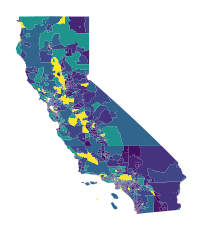

In [56]:
ax = ff_vizbucket.plot(
    column = "avg_risk_score_all",
    linewidth = 0
)

ax.axis('off')
# plt.savefig('zoom.png', dpi=300)